In [1]:
from pprint import pprint
import os, sys

# import reframe test script:
sys.path.append('../reframe') # so that next line can find reframe itself ...
import reframe_imb

import reframe

In [2]:
# NB: this is based on paths looking like:
# ../output/alaska/compute-roce/gnu-openmpi/IMB_PingPong/rfm_IMB_PingPong_job.out 
# ../perflogs/alaska/compute-roce/gnu-openmpi/IMB_PingPong/IMB_PingPong.log

In [3]:
# TODO: things in this cell should be moved to generic library
# TODO: see if we can automatically find that based on the jupyter root?

def group_by(seq, keyfunc):
    """ group a sequence of nested dicts using a keyfunction
    
        returns a dict of lists
        unlike itertools.groupby this returns a copy not an iterator
    
        TODO: explain properly
    """
    output = {}
    for item in seq:
        value = keyfunc(item)
        curr = output.setdefault(value, [])
        curr.append(item)
    return output

def find_run_outputs(root='.', test=None, ext='.out'):
    """ Find test files within an output tree.
    
        Args:
            root: path to start searching from
            test: str, limit results to directories which contain this string (default: all)
            ext: str, limit results to files with this extension
        
        Returns a sequence of str paths.
    """
    
    # directory is soemthing like:
    # ../output/sausage-newslurm/compute/gnu8-openmpi3/IMB_MPI1Test/
    
    # TODO: use reframe/reframe/frontend/cli.py code to get the current system, something like
    # import reframe
    # import reframe.core.config as config
    # import reframe.core.runtime as runtime
    # import os

    # # assume default location!
    # print(reframe.INSTALL_PREFIX)
    # config_file = os.path.join(reframe.INSTALL_PREFIX, 'reframe/settings.py')
    # settings = config.load_settings_from_file(config_file)
    # runtime.init_runtime(settings.site_configuration, options.system,
    #                              non_default_craype=options.non_default_craype)
    
    results = []
    for (dirpath, dirnames, filenames) in os.walk(root):
        # in-place filter dirnames to avoid hidden directories:
        for idx, d in enumerate(dirnames):
            if d.startswith('.'):
                del dirnames[idx]
        for f in filenames:
            if os.path.splitext(f)[-1] == ext:
                path = os.path.join(dirpath, f)
                testdir = os.path.basename(os.path.dirname(path))
                if test is None or test in testdir:
                    results.append(path)
    return(results)

def diff_meta(results, ignore=['path']):
    """ Given a sequence of results dicts, returns
            
            common, [difference1, difference2, ...]
        
        where each of these are dicts based on the ['meta'] properties of each result dict,
        ignoring given keys
        
        TODO: describe this properly
    """
    
    meta = [r['meta'].copy() for r in results]
    
    for key in ignore:
        for m in meta:
            m.pop(key, None)
    keyvals = [set(zip(m.keys(), m.values())) for m in meta]
    common = keyvals[0].intersection(*keyvals[1:])
    differences = [dict(b.difference(common)) for b in keyvals]
    return dict(common), differences

import datetime
def read_perflog(path):
    """ TODO: explain """
    
    # NB:
    # b/c perflog prefix is '%(check_system)s/%(check_partition)s/%(check_environ)s/%(check_name)s'
    # we know that this is unique for this combo - as it was for results
    
    perf_results = {'meta':reframe_imb.parse_path_metadata(path)}
    
    with open(path) as f:
        for line in f:
            # turn the line into a dict so we can access it:
            line = line.strip()
            # TODO: read this from reframe-settings handlers_perflog.filelog.format? (is adapted tho)
            LOG_FIELDS = 'completion_time,reframe,info,jobid,perf_data,perf_unit,perf_ref'.split(',')
            record = dict(zip(LOG_FIELDS, line.split('|')))
            
            # process values:
            perf_var, perf_value = record['perf_data'].split('=')
            record['perf_value'] = float(perf_value) # TODO: is this always right?
            record['completion_time'] = datetime.datetime.fromisoformat(record['completion_time'])
            
            # make sure we have a dict of lists for this perf_var:
            # NB unit and ref shouldn't change but best place to store them
            result_fields = ('completion_time', 'jobid', 'perf_value', 'perf_unit', 'perf_ref', 'reframe')
            var_results = perf_results.setdefault(perf_var, {})
            
            # append fields from this record:
            for k in result_fields:
                var_results.setdefault(k, list()).append(record[k])
    
    return perf_results


def sizeof_fmt(num, suffix='B'):
    """ TODO: """
    # from https://stackoverflow.com/a/1094933/916373
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

In [4]:
# find and load output files:
run_outputs = find_run_outputs('../output', 'IMB')

# load results using the same function that we use for reframe performance tests:
results = []
for path in run_outputs:
    result = reframe_imb.read_imb_out(path)
    results.append(result)

# Group results by *testname*
test_results = group_by(results, lambda x: x['meta']['testname'])

print('loaded %s output files with %i tests' % (len(results), len(test_results)))
# for test, cases in test_results.items():
#     print(test, ':')
#     for c in cases:
#         print('  ', c['meta']['filename'])
#         #pprint(c['meta'])

loaded 4 output files with 2 tests


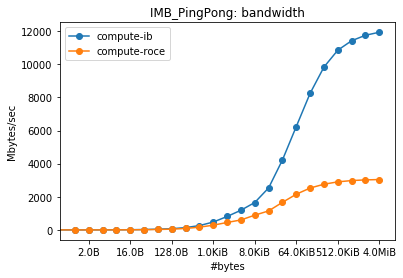

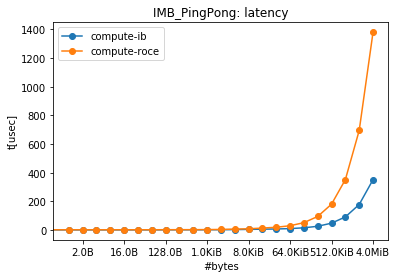

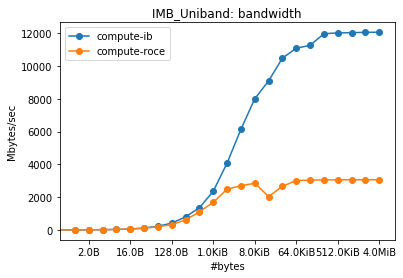

In [5]:
# Plotting:

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker

PLOTS = [
    {
        'test':'IMB_PingPong',
        'xaxis':'#bytes',
        'yaxis':'Mbytes/sec',
        'metric':'bandwidth',
    },
    {
        'test':'IMB_PingPong',
        'xaxis':'#bytes',
        'yaxis':'t[usec]',
        'metric':'latency',
    },
    {
        'test':'IMB_Uniband',
        'xaxis':'#bytes',
        'yaxis':'Mbytes/sec',
        'metric':'bandwidth',
    },   
]

for plot in PLOTS:
    cases = test_results[plot['test']]
    common, differences = diff_meta(cases)
    plt.figure()
    for ix, case in enumerate(cases):
        
        data = case['data'] # TODO: change this cope with benchmark name in output instead of fixed "data" key
        unique_meta = differences[ix]
        label = '-'.join(list(unique_meta.values()))
        #plt.plot(data[plot['xaxis']], data[plot['yaxis']], 'o-', label=label)
        plt.plot(data[plot['xaxis']], data[plot['yaxis']], 'o-', label=label)
        plt.grid()
        plt.title('%s: %s' % (plot['test'], plot['metric']))
        plt.legend()
        plt.grid()
        ax = plt.gca()
        ax.set_xscale('log', basex=2)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: sizeof_fmt(x)))
        plt.xlabel(plot['xaxis'])
        plt.ylabel(plot['yaxis'])
    

In [6]:
# example of loading test objects - don't actually need this yet

# def get_tests(module):
#     tests = []
#     for name in dir(module):
#         obj = getattr(module, name)
#         if isinstance(obj, reframe.core.meta.RegressionTestMeta):
#             tests.append(obj)
#     return tests
# testobjs = get_tests(reframe_imb)
# print(testobjs)

In [7]:
# Load performance records

# find relevant perf logs:
perf_outputs = find_run_outputs('../perflogs', 'IMB', '.log')

# load them:
perf_records = []
for path in perf_outputs:
    records = read_perflog(path)
    perf_records.append(records)

# group performance data by testname:
test_perf = group_by(perf_records, lambda x: x['meta']['testname'])

print('loaded %s performance logs with %i tests' % (len(perf_outputs), len(test_perf)))

loaded 4 performance logs with 2 tests


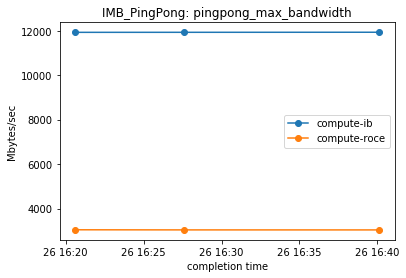

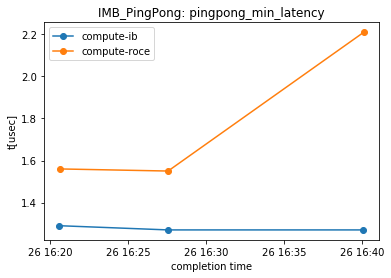

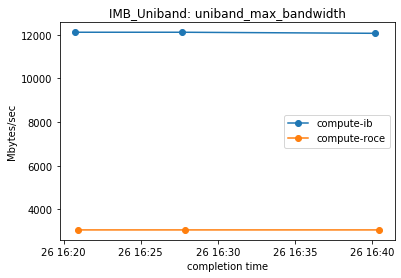

In [8]:
# Plot: NB for perf logs we don't need to define the plots because they can automatically be derived

import datetime

from matplotlib.dates import date2num

# plotting:
for test in test_perf:
    axes = {}
    cases = test_perf[test]
    common, differences = diff_meta(cases)
    for ix, case in enumerate(cases):
        
        unique_meta = differences[ix]
        for perf_var in case:
            if perf_var == 'meta': # not a real performance var
                continue
            
            # annoyingly can't use setdefault as this always evalutes `default`, so:
            if perf_var not in axes:
                axes[perf_var] = plt.subplots(nrows=1, ncols=1)
            fig, ax = axes[perf_var]            
            #dates = [datetime.datetime.fromisoformat(d) for d in case[perf_var]['completion_time']]
            dates = case[perf_var]['completion_time']
            values = case[perf_var]['perf_value']
            label = '-'.join(list(unique_meta.values()))
            ax.plot_date(dates, values, 'o-', label=label)
            ax.set_title('%s: %s' % (test, perf_var))
            ax.legend()
            ax.grid()
            ax.set_xlabel('completion time')
            ax.set_ylabel(case[perf_var]['perf_unit'][0]) # shouldn't matter which unit is used
        